In [1]:
%gui qt
%matplotlib notebook

import pickle
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import pdb
import KF2D
import os,glob
import matplotlib.pyplot as plt
import colortrack as ct
import cPickle
import csv,ast

In [63]:
def slidingWindow(sequence,winSize,step=1):
    """Returns a generator that will iterate through
    the defined chunks of input sequence.  Input sequence
    must be iterable. Iterable returns window values and index"""
 
    # Verify the inputs
    try: it = iter(sequence)
    except TypeError:
        raise Exception("**ERROR** sequence must be iterable.")
    if not ((type(winSize) == type(0)) and (type(step) == type(0))):
        raise Exception("**ERROR** type(winSize) and type(step) must be int.")
    if step > winSize:
        raise Exception("**ERROR** step must not be larger than winSize.")
    if winSize > len(sequence):
        raise Exception("**ERROR** winSize must not be larger than sequence length.")
 
    # Pre-compute number of chunks to emit
    numOfChunks = ((len(sequence)-winSize)/step)+1
 
    # Do the work
    for i in range(0,numOfChunks*step,step):
        yield sequence[i:i+winSize],i

def lenCheck(red_kf, yellow_kf):
    if len(red_kf[0])>len(yellow_kf[0]):
        row = []
        for i in range(len(red_kf)):
            row.append(red_kf[i][:len(yellow_kf[0])])
        red_kf = row[:]
    elif len(red_kf[0])<len(yellow_kf[0]):
        row = []
        for i in range(len(yellow_kf)):
            row.append(yellow_kf[i][:len(red_kf[0])])  
        yellow_kf = row[:]
    len(red_kf[0]),len(yellow_kf[0])
    return red_kf,yellow_kf

#Plot to compare RED raw data to KF and KF-smoothed.
def plotKF(red_kf, yellow_kf):
    plt.figure()
    # for i in range(len(redmat)):
    #     plt.plot(redmat[i][0],redmat[i][1],'r.')
    #     plt.plot(yellowmat[i][0],yellowmat[i][1],'y.')
    plt.plot(red_kf[2][:,0],red_kf[2][:,1],'b-',linewidth=2,label='red - KF filter'),
    plt.plot(red_kf[0][:,0],red_kf[0][:,1],'c:',label='red - KF & smooth'),

    plt.plot(yellow_kf[2][:,0],yellow_kf[2][:,1],'k-',linewidth=2,label='yellow -KF filter'),
    plt.plot(yellow_kf[0][:,0],yellow_kf[0][:,1],':',color='orange',label='yellow - KF & smooth'),

    plt.legend()
    plt.title(m)
    plt.xlabel('Horizontal position (cm)')
    plt.ylabel('Vertical position (cm)')
    plt.show()

def convertdData(data_pd):
    try:
        red_pd = data_pd['red']
        yellow_pd = data_pd['yellow']
        
        redmat=[]
        yellowmat = []
        midmat = []
        frames = []

        for i in range(len(red_pd)):
            row = red_pd[i]
            #red += [[row[0][0],row[0][1], row[1]]]
            redmat += [row[0]]#, row[2][0]]]

        for row in yellow_pd:
            #yellow += [[row[0][0],row[0][1], row[1]]]
            yellowmat += [row[0]]#, row[2][0]]]
        frames = range(100,len(redmat)-100)

    except KeyError:
        red_pd = data_pd[['red_x', 'red_y']].copy()
        yellow_pd = data_pd[['yellow_x', 'yellow_y']].copy()
        first = int(float(data_pd['frames'][0]))
        frames = range(first,len(data_pd)-first)
        
    return red_pd, yellow_pd, frames

#red_pd = pd.DataFrame(red_pd, columns = ['x','y','frame'])
#yellow_pd = pd.DataFrame(yellow_pd, columns = ['x','y','frame'])

def saveRaw(red_kf, yellow_kf):
    if len(red_kf[0])!=len(yellow_kf[0]):
        print("Lengths don't match. Aborting!")
    else:
        sm_red = np.array(red_kf[0])#export only smooth data
        sm_yellow = np.array(yellow_kf[0])

        frames = range(100,len(sm_red)+100)
        print(len(frames))

        rot_dir = 'unk'# input('Enter rotation direction: CW or CCW. ')

        #TODO: improve this
        T = []
        rotation = []
        for row in sm_red.T[0]:
            T.append(row/25)
            rotation.append(rot_dir)

        #KF output columns are: x,y,dx,dy
        try:
            raw_data = np.column_stack((sm_red, sm_yellow, frames, rotation))
        except:
            print ('Red_kf, yellow_kf, frames, and rotation are not all the same lenght. Fix and retry.')
    #     raw_data = np.column_stack((red_pred[0][:,0].T,red_pred[0][:,1].T,red_pred[0][:,2].T,red_pred[0][:,3].T,\
    #                        yellow_pred[0][:,0].T,yellow_pred[0][:,1].T,yellow_pred[0][:,2].T,yellow_pred[0][:,3].T,\
    #                        frames,rotation))
        raw_pd = pd.DataFrame(raw_data, columns = ['red_x','red_y','red x vel','red y vel','yellow_x',\
                                     'yellow_y','yellow x vel','yellow y vel','frames','rotation_direction'])

        filename = m[:-5]+'raw.p'
        print(filename)
        #c = raw_input('Continue? (y/n)' )
        c='y'
        if c != 'y':
            filename = input("Enter entire file name with extension. Format = 'ID_SPDrpm_DATE_raw.p': ")

        os.chdir('/Users/sazamore/Documents/Visuomotor/1-Raw_data')
        raw_pd.to_pickle(filename)
        print('File saved!')
        return raw_pd

def convert2DF(data_pd):
    datamat = {'red_x':[],'red_y':[],'yellow_x':[],'yellow_y':[],'frames':[]}
    for i in range(len(data_pd['red'])):
        pdb.set_trace()
        datamat['red_x'].append(data_pd['red'][i][0][0])
        datamat['red_y'].append(data_pd['red'][i][0][1])
        datamat['yellow_x'].append(data_pd['yellow'][i][0][0])
        datamat['yellow_y'].append(data_pd['yellow'][i][0][1])
        datamat['frames'].append(data_pd['red'][i][1])
        data_pd = pd.DataFrame(datamat)
    return data_pd

def get_center(event,x,y,flags,param):			
    """Finds center of an image using mouse click"""
    if event == cv2.EVENT_LBUTTONDOWN:
        frameCenter = (x,y)
#         cv2.circle(frame,(x,y),10,(0,0,0),-1)
#         cv2.imshow('Click on center', frame)
        print('Center is '+ str(frameCenter))
        color_data["frameCenter"] = frameCenter
        cv2.destroyWindow('Click on center')

def calibrate(x,y,frame):
    """This function adjusts the (x,y) outputs of all tracked data and moves the origin to the center determined
    by get_center()"""
    #TO DO: adjust for dataframe input
    convers = (44.45/2.)/param_data['diameter'] #convert pixels to cm
    new_x=[]
    new_y = []
    #default origin is the upper left corner of an image.
    
    if frameCenter == []:
        print ('Center not found')
#         pdb.set_trace()
        camera = cv2.VideoCapture('/Volumes/ADIPOSE/94/Videos/94_170503_4rpm.mp4')
        (grabbed,frame) = camera.read(100)
        scale = 1300./frame.shape[1]
        frame = cv2.resize(frame,None,fx=scale,fy=scale,interpolation = cv2.INTER_CUBIC)
        frame = frame[global_data['upperPt'][1]:global_data['lowerPt'][1],global_data['upperPt'][0]:global_data['lowerPt'][0]]
        if grabbed:
#             cv2.imshow('Click on center',frame)
            cv2.setMouseCallback('Click on center',get_center)
            cv2.waitKey(5000)
            print(frameCenter)

    for i in range(len(x)):
        new_x.append([(float(x[i]) - frameCenter[0])*convers,(float(y[i]) - frameCenter[0])*convers])#param_data['frameCenter'][0])*convers)
        #new_y.append((float(y[i]) - frameCenter[0])*convers)#param_data['frameCenter'][1])*convers)

    return np.array(new_x)

def calibPts(ID,red_pd,yellow_pd,r_idx,y_idx):
    print('Calibrating data...')
    #os.chdir('/Volumes/ADIPOSE/90/vidParam')
    #filename = ID[:-2]+".mp4"
    paramfile = ID[:-2]+'_data.p'#ID[:-6]+"_data.p"
    print(paramfile)
    global param_data, global_data,frameCenter
    
#     try:
#         param_data = pickle.load(open(paramfile,"rb"))  #import video-specific data
#     except NameError:
#         'File not found in folder. param_data not loaded.'
        
    try:
        globalfile = '94_00_161130-global.p'#paramfile[:2]+'_00_0' + ID[10:14] +'-global.p'
        print(globalfile)
#         os.chdir('/Volumes/ADIPOSE/94/vidParam')
        os.chdir('/Users/sazamore/BehaviorVids/94/vidParam')
        global_data = pickle.load(open(globalfile,"rb"))  #import batch-specific data
        if not param_data['frameCenter']:
            frameCenter =(313,308)
#             frameCenter = global_data['frameCenter']

    except NameError:
        'File not found in folder. global_data not loaded.'

    red_data = calibrate(red_pd['x'].as_matrix(),red_pd['y'].as_matrix(),red_pd['frames'].as_matrix())
    yellow_data = calibrate(yellow_pd['x'],yellow_pd['y'],yellow_pd['frames'])
    
    #keep zeros as zeros or it'll mess shit up
    for i in y_idx:
        yellow_data[i][0]=0#[0][i] = 0.
        yellow_data[i][1]=0#[1][i] = 0.
    for i in r_idx:
        red_data[i][0]=0#[0][i] = 0.
        red_data[i][1]=0#[1][i] = 0.
        
    print('Calibration complete. Please save data.')
    return red_data, yellow_data


In [3]:
for m in files:
#openfile = str(raw_input('Enter full file name. No apostrophes. '))
#'90_02rpm_170201_early.p'

data_pd = pd.read_pickle(m)

IndentationError: expected an indented block (<ipython-input-3-f19fa687a1bd>, line 5)

In [114]:
#For pickle files
# os.chdir('/Volumes/ADIPOSE/90/Tracked-raw')#/Raw_data')
os.chdir('/Users/sazamore/BehaviorVids/94/mp4')
# os.chdir('/Users/sazamore/Documents/Visuomotor/1-Raw_data')
files = glob.glob('94_161130_10rpm.csv')
# files = glob.glob('94*')
paramfile = '94_161130_04rpm_data.p'

files

['94_161130_10rpm.csv']

In [115]:
m=files[0]
# for m in files:
#     global m
#openfile = str(raw_input('Enter full file name. No apostrophes. '))
#'90_02rpm_170201_early.p'

    #os.chdir('/Volumes/ADIPOSE/90/vidParam')#'/Users/sazamore/BehaviorVids/90')
# with open(m, 'rb+') as myfile:
#     data_pd = cPickle.load(myfile)
print m


94_161130_10rpm.csv


In [116]:
if m[-1]=="p":
    data_pd = pd.read_pickle(m)
    frames = data_pd['frames'].astype(float)
else:
    data_pd = pd.read_csv(m)
    red = data_pd['0'][1]
    yellow = data_pd['0'][6]
    frames = data_pd['0'][3]
    rframes = data_pd['0'][5]

    red = np.array(ast.literal_eval(red))
    yellow = np.array(ast.literal_eval(yellow))
    yellowmat = np.column_stack([np.transpose(yellow)[0],np.transpose(yellow)[1]])
    frames = ast.literal_eval(frames)
#     yellowmat = np.column_stack
#You will get a malformed string error if there are nans in the string....which there probably will be. Have fun!

In [117]:
# if m[-5:-2]=='raw' or isinstance(data_pd, pd.DataFrame):
#     red_pd = data_pd[['red_x', 'red_y','frames']].copy()
#     yellow_pd = data_pd[['yellow_x', 'yellow_y','frames']].copy()
# elif m[-1]=='v':
#     red_pd =  {'x':[],'y':[],'frames':[]}
#     yellow_pd = {'x':[],'y':[],'frames':[]}
#     #yellow_pd = {}
#     for row in data_pd['red'].values():
#         red_pd['x'].append(row[0][0])
#         red_pd['y'].append(row[0][1])
#         red_pd['frames'].append(row[1])
#     for row in data_pd['yellow'].values():
#         yellow_pd['x'].append(row[0][0])
#         yellow_pd['y'].append(row[0][1])
#         yellow_pd['frames'].append(row[1])
#     red_pd = pd.DataFrame(data = red_pd,columns = red_pd.keys())
#     yellow_pd = pd.DataFrame(data = yellow_pd,columns = yellow_pd.keys())

yellow_pd = {'x':[],'y':[],'frames':[]}
yellow_pd['x']= yellow.T[0]
yellow_pd['y']= yellow.T[1]
yellow_pd['frames']= frames
yellow_pd = pd.DataFrame(data = yellow_pd, columns = ['x', 'y','frames'])

red_pd = {'x':[],'y':[],'frames':[]}
red_pd['x']= red.T[0]
red_pd['y']= red.T[1]
red_pd['frames']= rframes
red_pd = pd.DataFrame(data = red_pd, columns = ['x', 'y','frames'])
    
if len(red_pd)<len(yellow_pd):
    yellow_pd = yellow_pd.drop(yellow_pd.index[-1])
    print(len(yellow_pd),len(red_pd))
elif len(red_pd)>len(yellow_pd):
    red_pd.drop(red_pd.index[-1])
    print(len(yellow_pd),len(red_pd))

red_pd.columns = ['x', 'y','frames']
yellow_pd.columns = ['x', 'y','frames']
r_idx = list(np.where(red_pd['x']==0)[0])
y_idx = list(np.where(yellow_pd['x']==0)[0])

#frameCenter = (326, 327)
current = os.getcwd()
# os.chdir('/Volumes/ADIPOSE/94/vidParam')
os.chdir('/Users/sazamore/BehaviorVids/94/vidParam')
# paramfile = glob.glob(vid[:-2]+'_data.p')
global param_data
param_data = pickle.load(open(paramfile, "rb" ) )
# frameCenter = global_data['frameCenter']
#param_data['frameCenter'] = frameCenter
frameCenter = (313,308) #94_170329

if np.mean(red_pd['x']>100):
    redmat, yellowmat = calibPts(m,red_pd,yellow_pd,r_idx,y_idx)
else:
    print('Files already calibrated. Run Make_rawfile.')

Calibrating data...
94_161130_10rpm.c_data.p
94_00_161130-global.p
Calibration complete. Please save data.


In [16]:
data_pd['red_x'][np.where(data_pd['red_x']==0)[0]]=np.nan
data_pd['red_y'][np.where(data_pd['red_y']==0)[0]]=np.nan
data_pd['yellow_x'][np.where(data_pd['yellow_x']==0)[0]]=np.nan
data_pd['yellow_y'][np.where(data_pd['yellow_y']==0)[0]]=np.nan
# 
# data_pd

KeyError: 'red_x'

In [57]:
#Data processed after 10/24/17 will be dataframes. Use this:
try:
    redmat = np.column_stack([data_pd['red_x'].astype(float),data_pd['red_y'].astype(float)])
    yellowmat = np.column_stack([data_pd['yellow_x'].astype(float),data_pd['yellow_y'].astype(float)])
except:
    data_pd = convert2DF(data_pd)
    redmat = np.column_stack([data_pd['red_x'].astype(float),data_pd['red_y'].astype(float)])
    yellowmat = np.column_stack([data_pd['yellow_x'].astype(float),data_pd['yellow_y'].astype(float)])

KeyError: 'red'

In [104]:
red_data

array([[-2.05721915,  9.5476068 ],
       [-1.91655459,  9.5476068 ],
       [-1.74072389,  9.61793908],
       ..., 
       [ 3.30561709, -1.91655459],
       [ 3.21770174, -2.05721915],
       [ 3.23528481, -2.02205301]])

In [118]:
# frames = data_pd['Frame'].astype(float) # for gap bridging data
#pdb.set_trace()

red_kf = KF2D.fill_in_data(redmat,frames,smooth=300,fs=30.)
yellow_kf = KF2D.fill_in_data(yellowmat,frames,300,30.)
# print(len(red_kf[0]),len(yellow_kf[0]))

red_kf,yellow_kf = lenCheck(red_kf,yellow_kf)

#     constants = np.where(np.diff(red_kf[2][:,2])==0)[0]
#     skew = np.diff(constants)
#     idx = []
#     chunks = slidingWindow(skew,15,1)
#     for chunk in chunks:
#         if np.all(chunk[0]==1):
#             idx.append(chunk[1])
#     idx
#WHAT DO I DO HERE?! Panic.
#pdb.set_trace()

> /Users/sazamore/BehaviorVids/94/vidParam/KF2D.py(30)fill_in_data()
(Pdb) c
> /Users/sazamore/BehaviorVids/94/vidParam/KF2D.py(30)fill_in_data()
(Pdb) c


<IPython.core.display.Javascript object>


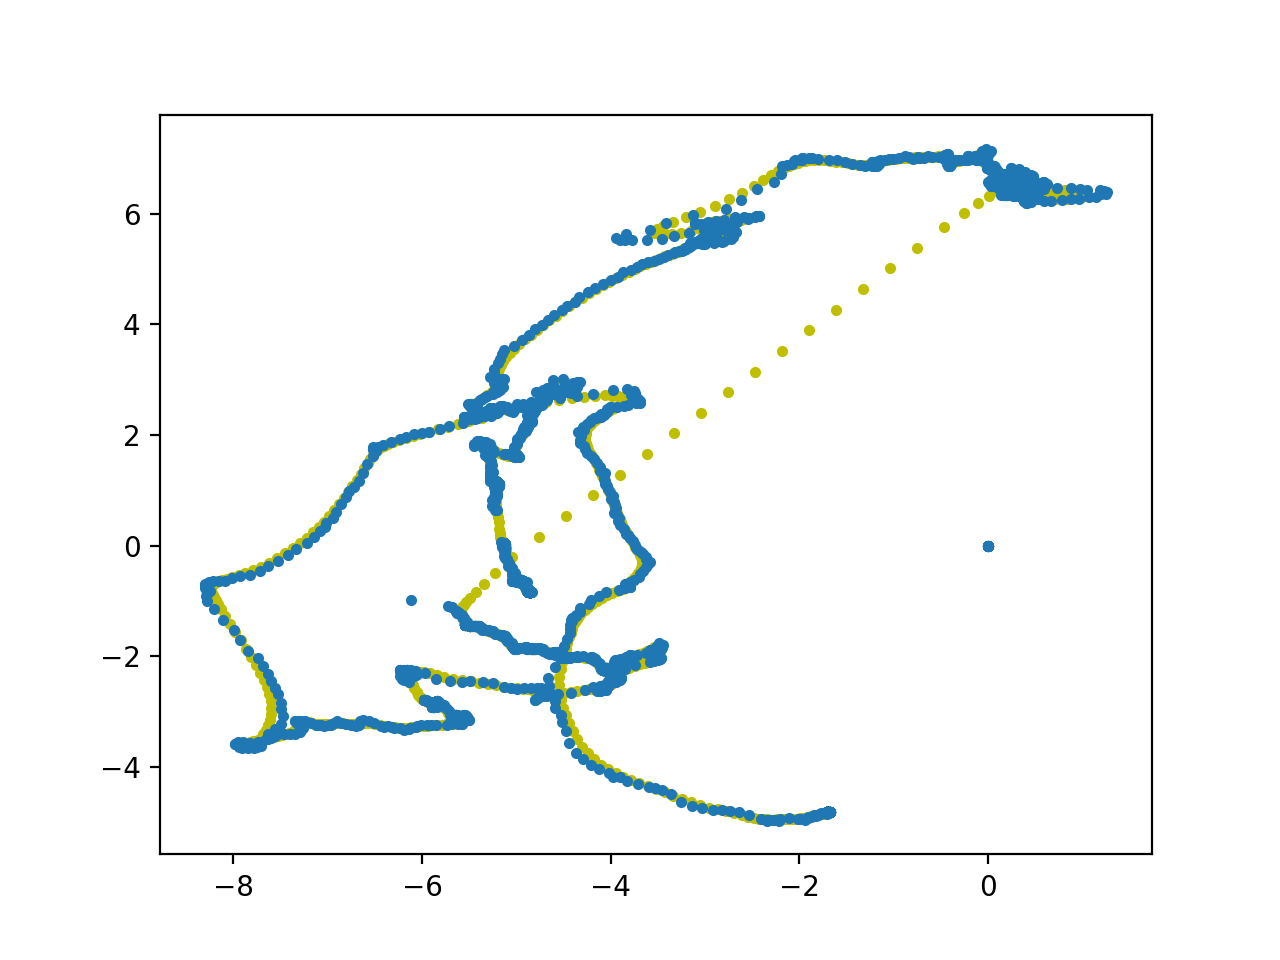

In [119]:
plt.figure()
# plt.plot(yellow_kf[0].T[0].astype(float)-red_kf[0].T[0].astype(float))
# plt.plot(yellow_kf[0].T[1].astype(float)-red_kf[0].T[1].astype(float))

plt.plot(yellow_kf[0].T[0],yellow_kf[0].T[1],'y.')
# plt.plot(data_pd['yellow_y'],'.')
plt.plot(yellowmat.T[0],yellowmat.T[1],'.')
# plt.plot()
# plt.xlim([-10.,600])
# plt.ylim([-1000,4000])
plt.legend()

In [120]:
raw_pd = saveRaw(red_kf, yellow_kf)

4349
94_161130_10rpraw.p
File saved!


In [66]:
raw_pd

,red_x,red_y,red x vel,red y vel,yellow_x,yellow_y,yellow x vel,yellow y vel,frames,rotation_direction
0,-0.0030602365075,0.0126375698069,0.000236967386915,0.000140985921324,-0.00366226551978,0.0132923972832,0.000226974795241,0.000152249526735,100,unk
1,10.0578797886,59.2510247774,0.0454398226583,0.284365697099,10.2389195516,57.2469501241,0.0428149231051,0.277709656774,101,unk
2,20.1189731698,118.490372799,0.0775740718192,0.483203085467,20.4816455548,114.481545568,0.0730194071555,0.472139995721,102,unk
3,30.180175871,177.73039701,0.0966397148695,0.596653151026,30.7244740039,171.716801639,0.0908404269464,0.58344326637,103,unk
4,40.2414438555,236.970812785,0.102636751809,0.624715893775,40.967363159,228.952441246,0.0962779824778,0.611619468718,104,unk
5,46.2019578696,268.842400796,0.101923541017,0.608963675236,48.2276796641,259.866325755,0.0954120150755,0.597546848295,105,unk
6,50.5515539966,285.242508431,0.0978428614131,0.571290350383,53.7105646341,275.752654943,0.0914383830124,0.562697833246,106,unk
7,53.7383927017,292.363337148,0.0923978054908,0.524791250376,58.0992447578,282.920298175,0.0862095932177,0.519517554626,107,unk
8,56.2936802461,294.02101449,0.0867690388179,0.47719153215,61.504220768,284.727830359,0.0808485800738,0.475537986404,108,unk
9,58.4447844715,292.4799316,0.0816455490943,0.432996282617,64.3358777351,283.175798671,0.0760640025044,0.435518207823,109,unk


In [70]:
data_pd = pd.read_csv(m,skiprows=5,header=None)  #for gap bridging data
data_pd = data_pd.copy([0,2,3]) #for gap bridging data
datamat = np.column_stack([data_pd[2].astype(float),data_pd[3].astype(float)])
data_KF = KF2D.fill_in_data(datamat,datamat[0].astype(int),300,30.)
pickle.dump( data_KF[0], open( "85_gap3_2-raw.p", "wb" ) )

CParserError: Error tokenizing data. C error: Expected 1 fields in line 24, saw 3


<IPython.core.display.Javascript object>


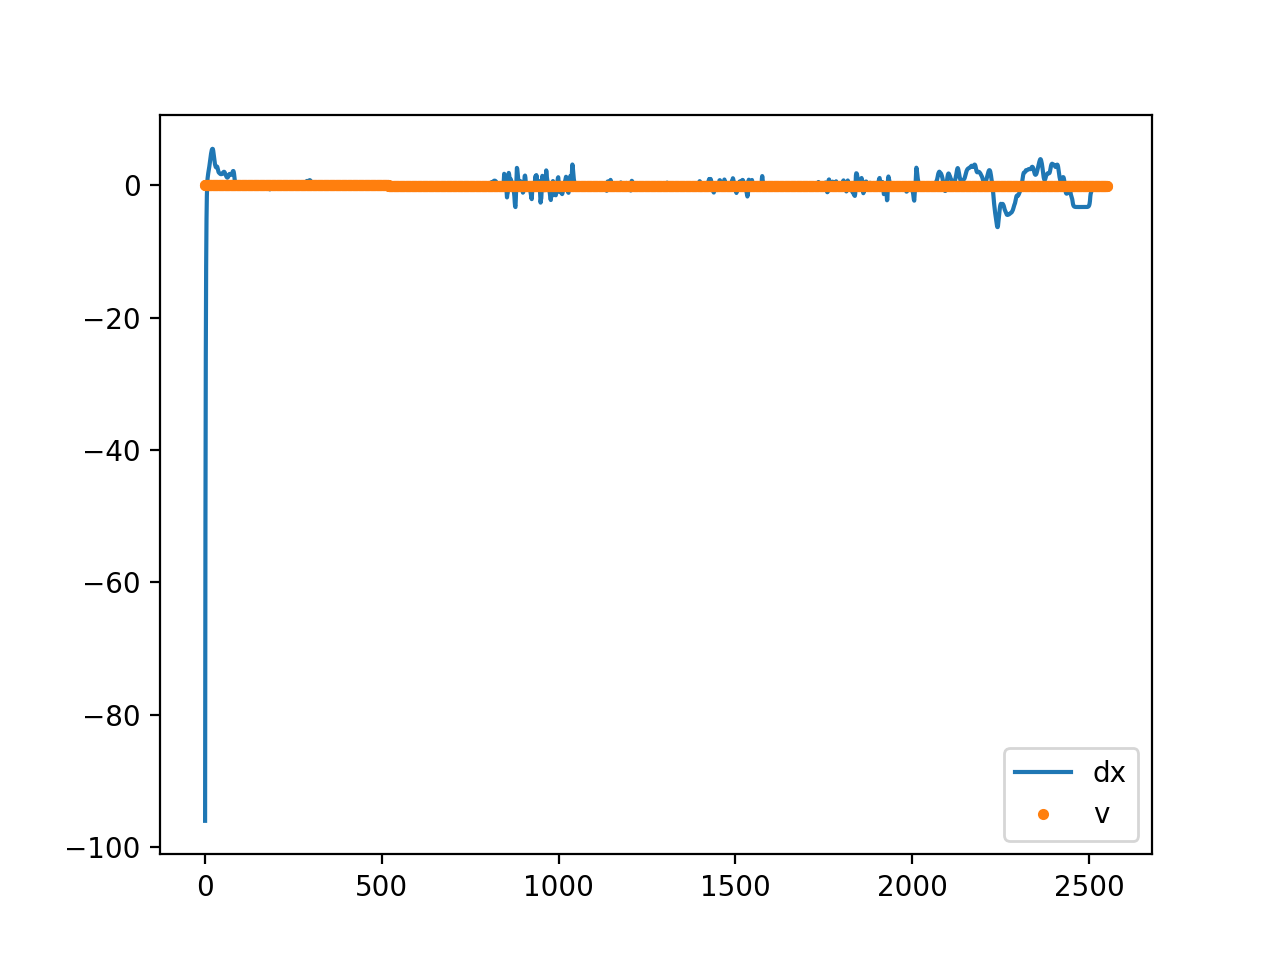

In [67]:
plt.figure()
plt.plot(np.diff(red_kf[0].T[0])*25,label='dx')
plt.plot(red_kf[0].T[2],'.',label='v')
plt.legend()
plt.show()

In [36]:
zloc = np.where(redmat[:,0]==redmat[0])[0]
redmat[zloc]=0

<IPython.core.display.Javascript object>


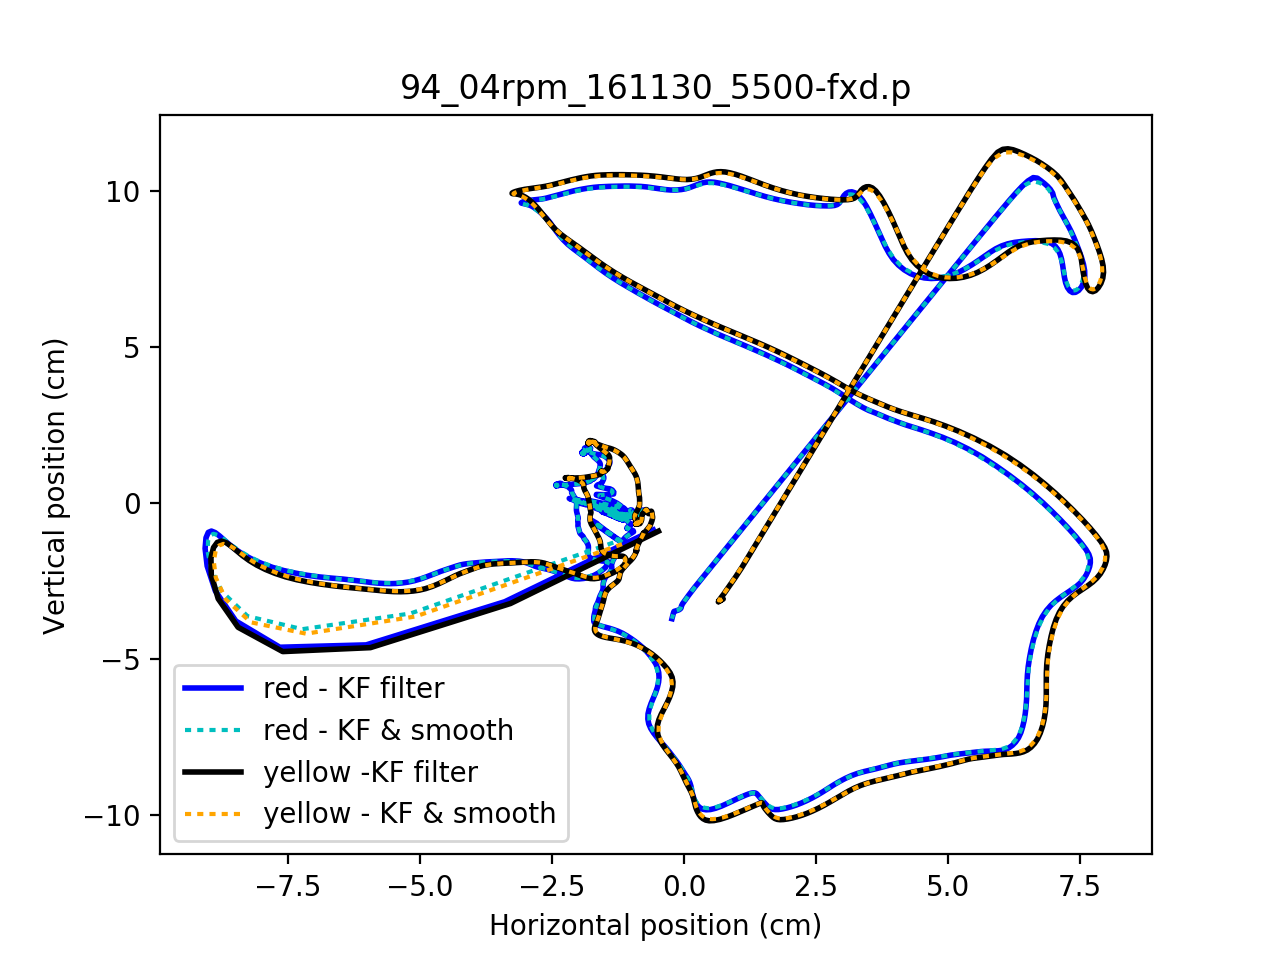

In [68]:

plotKF(red_kf, yellow_kf)

# plt.figure()
# plt.plot(red_kf[2][:,0])
# plt.plot(yellowmat[:5803,0],yellowmat[:5803,1],'.')
# plt.plot(yellowmat[:5803],'.')



In [253]:
np.diff(red_kf[0][15796:15810].T)
test = red_kf[0][:15796]
# test.shape, red_kf.shape
test.shape
short_red = red_kf[0][:6924]
short_yell = yellow_kf[0][:6924]
test = [short_red, red_kf[1:]]
red_kf = [short_red,red_kf[1:]]
yellow_kf = [short_yell, yellow_kf[1:]]

<IPython.core.display.Javascript object>


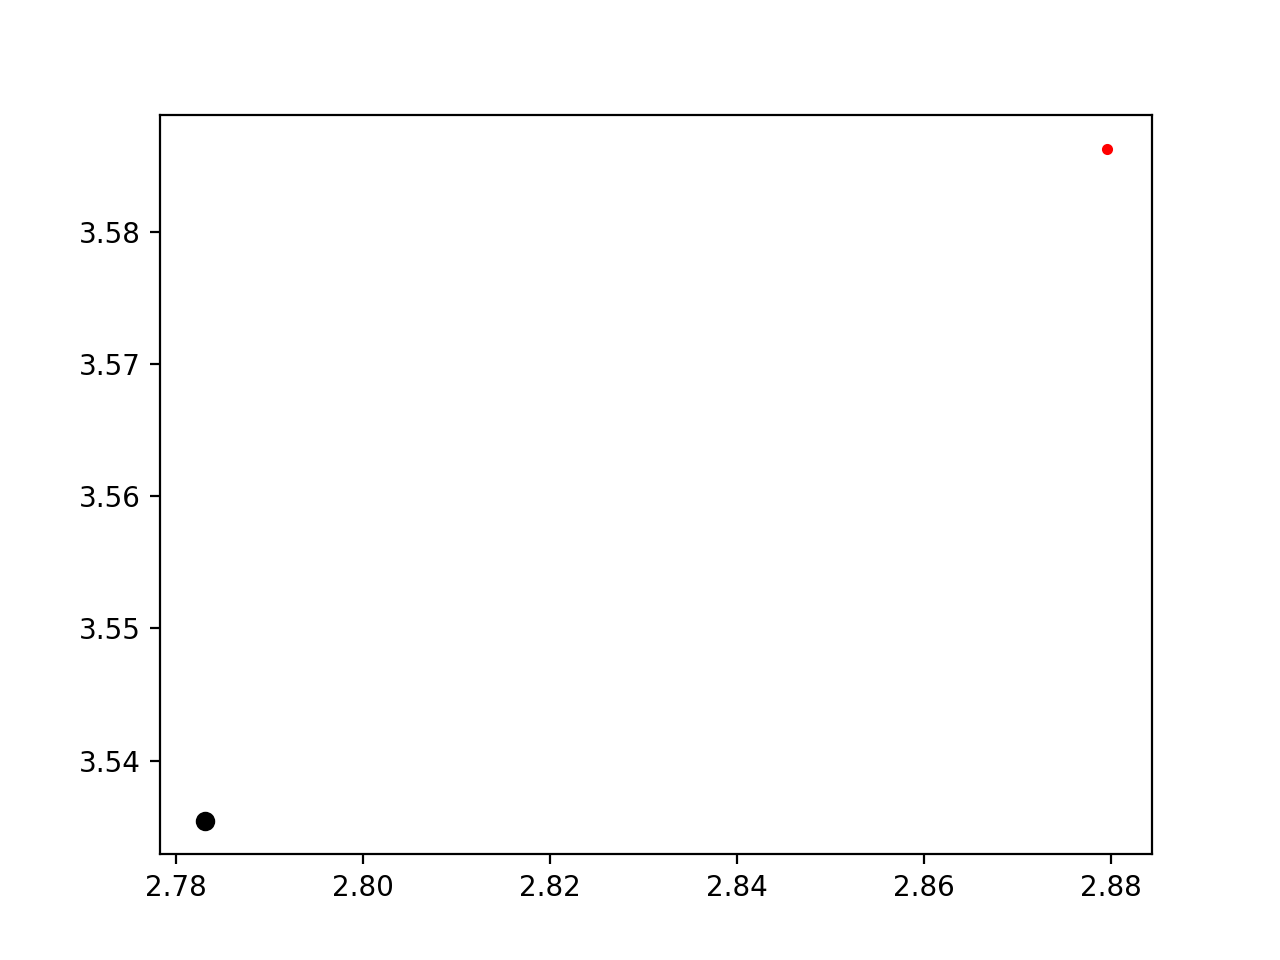

In [75]:
plt.figure()
convers = (44.45/2.)/630
i = 2000
dx = float(data_pd['red x vel'][i])*convers
dy = float(data_pd['red y vel'][i])*convers
plt.plot(fixed_pd['red_x'][i]+dx,fixed_pd['red_y'][i]+dy,'ko')
plt.plot(fixed_pd['red_x'][i-1],fixed_pd['red_y'][i-1],'r.')
plt.show()

In [63]:
fixed_pd = pd.read_pickle('90_03rpm_170201_fxd_raw.p')
data_pd = pd.read_pickle('90_03_170201_raw.p')

In [16]:
constants = np.where(np.diff(red_kf[2][:,2])==0)[0]
skew = np.diff(constants)
idx = []
chunks = slidingWindow(skew,15,1)
for chunk in chunks:
    if np.all(chunk[0]==1):
        idx.append(chunk[1])
idx
#Replace with NaNs!

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 162,
 163,
 164,
 241,
 242,
 243,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 490,
 491,
 492,
 493,
 494,
 495,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 702,
 703,
 704,
 705,
 706,
 707,
 708,
 709,
 710,
 711,
 712,
 713,
 714,
 715,
 716,
 717,
 718,
 719,
 720,
 721,
 722,
 723,
 724,
 725,
 726,
 727,
 728,
 729,
 730,
 731,
 732,
 733,
 734,
 735,
 736,
 737,
 760,
 761,
 762,
 763,
 764,
 765,
 766,
 1180,
 1181,
 1182,
 1183,
 1184,
 1185,
 1186,
 1187,
 1188,
 1189,
 1190,
 1191,
 1192,
 1193,
 1194,
 1195,
 1196,
 1197,
 1198,
 1199,
 1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1212,
 1213,
 1214,
 1215,
 1216,
 1217,
 1218,
 1219,
 1220,
 1221,
 1222,
 

<IPython.core.display.Javascript object>


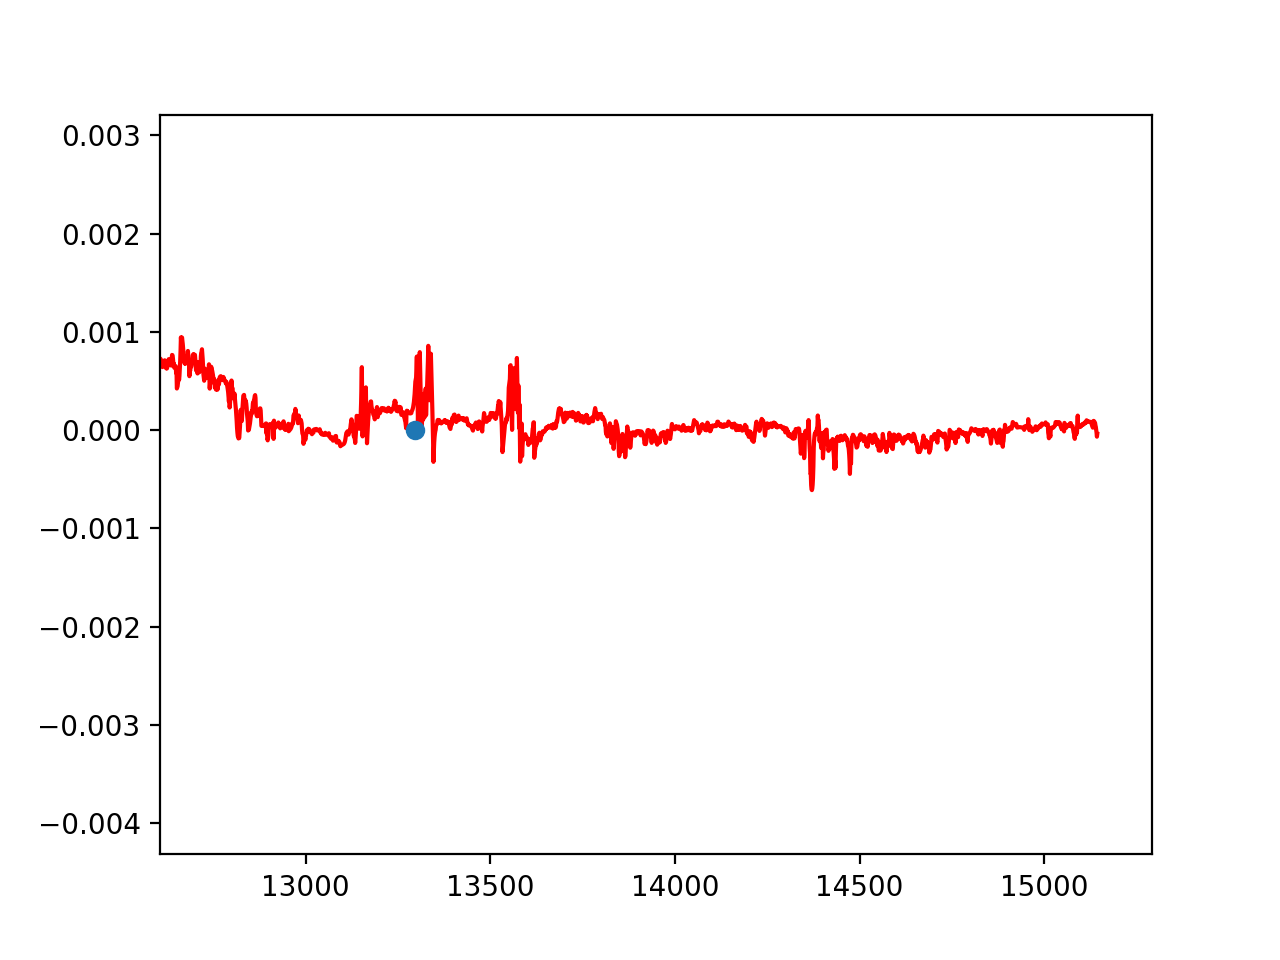

In [17]:

plt.figure()
plt.plot(np.diff(red_kf[0][:,2]),'r')
plt.plot(constants[chunk[1]+2],0,'o')
#plt.plot(red_kf[2][:,3],'b')
    
plt.legend()
# plt.xlabel('Horizontal position (cm)')
# plt.ylabel('Vertical position (cm)')
plt.show()

In [7]:
#Determine if noise is Guassian (can we use KF)
from scipy.optimize import curve_fit

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

mu = 0#np.mean(observations.T[0,:400])
sig = np.std(observations.T[0,:400])

def gauss (x, mu, sig):
    #p = [x0, y0, sigma]
    return np.exp(-(x-mu)**2 / (2 * sig**2))

h,n = np.histogram(observations.T[0,:400]-np.mean(observations.T[0,:400]))
fit = curve_fit(gauss, n[1:],h)

plt.figure()
plt.subplot(211)
#plt.hist(observations.T[0,:400]-np.mean(observations.T[0,:400]))
plt.plot(np.linspace(-.5,.5,num=100),170*gaussian(np.linspace(-.5,.5,num=100), mu, sig),'r')
plt.plot(mu, gaussian(mu,mu,sig),'ro')#np.mean(observations.T[0,:400]),0,'ro')
plt.ylabel('Count')

mu = 0#np.mean(observations.T[1,:400])
sig = np.std(observations.T[1,:400])

plt.subplot(212)
#plt.hist(observations.T[1,:400]-np.mean(observations.T[1,:400]))
plt.plot(np.linspace(-0.5,0.5,num=100),170*gaussian(np.linspace(-0.5,0.5,num=100), mu, sig),'r')
plt.plot(0,100,'ro')
plt.show()

NameError: name 'observations' is not defined

<IPython.core.display.Javascript object>


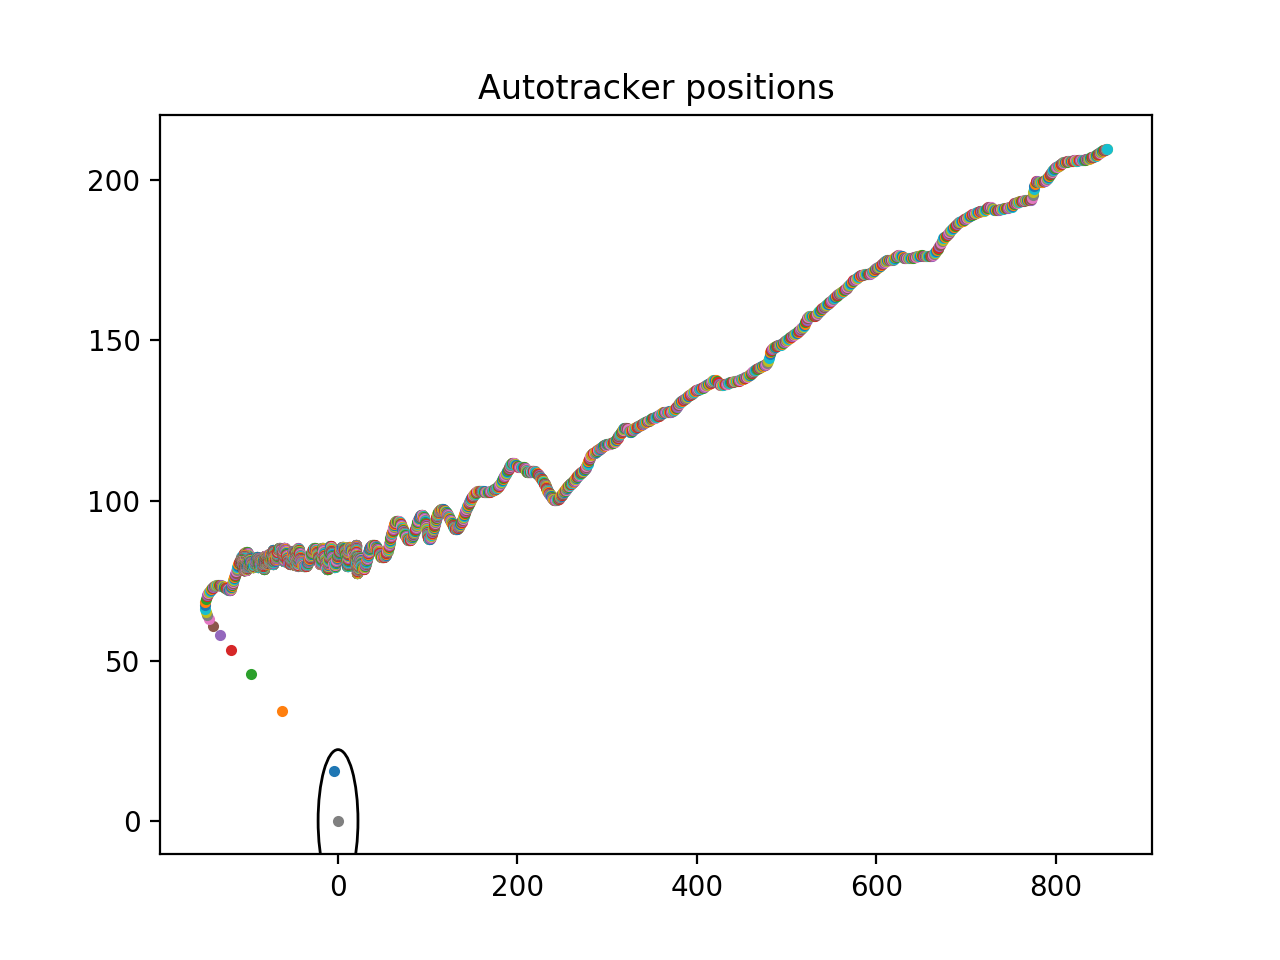

In [60]:
#Plot to look at raw tracked points.
fig = plt.figure()
ax = plt.axes()

for i in range(len(data_KF[2])):
#     plt.plot(yellow_kf[0][i,0],yellow_kf[0][i,1],'y.',red_kf[2][i,0],red_kf[2][i,1],'r.')
    plt.plot(data_KF[0][i,0],data_KF[0][i,1],'.')
plt.plot(0,0,'.',color='gray')

circ1 = plt.Circle((0,0),44.45/2,color='k',fill=False)
ax.add_artist(circ1)
plt.title('Autotracker positions')

# plt.xlim(-30,30)
# plt.ylim(-30,30)
plt.show()